In [62]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")

import numpy as np
import pandas as pd
import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

# ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# set Randomseed
RSEED = 42

# import needed functions
from modeling.processing import *

# Load the TensorBoard notebook extension
%load_ext tensorboard



2.8.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
# The maximum number of words to be used. (most frequent)
vocab_size = 50000

# Dimension of the dense embedding.
embedding_dim = 128

# Max number of words in each complaint.
max_length = 200

# Truncate and padding options
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [3]:
# load the dataset and use the first 500k (to be faster on testruns)

dataset = pd.read_csv('../data/yelp_dataset/review_1819.csv')
dataset = dataset[:500000]


In [4]:
# reduce dataset to text and rating
dataset = dataset[['text', 'stars']]

In [5]:
# filter for only english reviews
dataset = language_processing(dataset)

#remove the language line used for filtering
dataset.drop('language', axis=1, inplace=True)

In [6]:
# define stopwords and symbols to be deleted
stopwords = nltk.corpus.stopwords.words('english')
punctuation = ['?', '.', ':', ':', '!', '"', '(', ')', '-', '$', ',', '+', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', "'"]

#define function for textcleaning
def clean_text(text):   
    cleaned_text = "".join(u for u in text if u not in punctuation)
    cleaned_text = cleaned_text.lower()
    cleaned_text = ' '.join(word for word in cleaned_text.split() if word not in stopwords) 
    return cleaned_text

In [7]:
#apply function for textcleaning and make sure everything looks as planned
dataset["text"] = dataset["text"].apply(clean_text)
dataset

,text,stars
0,decide eat aware going take hours beginning en...,3.0
1,really stars one love th street naked tchopsti...,4.0
2,boyfriend tried deli first time today turkey a...,5.0
4,cafe extremely cute came even jazz band playin...,4.0
5,ive cannolis awesome theyre freshly filled ord...,5.0
...,...,...
499995,honestly thought would really love place made ...,1.0
499996,spent evening eating mexican repast chilango y...,4.0
499997,love food go location lot ordered traditional ...,1.0
499998,happy place opening around area owners staff e...,5.0


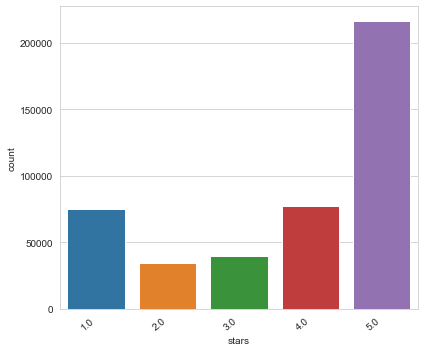

In [8]:
# plot the data distribution
sns.set_style('whitegrid')
plt.figure(figsize=(6, 5))
ax = sns.countplot(x='stars', data=dataset)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

In [9]:
# define feature and target
review = dataset["text"].values
stars = dataset[["stars"]].values

# split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(review, stars, test_size = 0.20, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(354530,) (354530, 1)
(88633,) (88633, 1)


In [10]:
#apply tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 164384 unique tokens.


In [24]:
# transform feature to tensors and pad for better comparison
train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print('Shape of train tensor:', train_padded.shape)
print('Shape of validation tensor:', test_padded.shape)

Shape of train tensor: (354530, 200)
Shape of validation tensor: (88633, 200)


In [25]:
# encode the target variable
encode = OneHotEncoder()

training_labels = encode.fit_transform(y_train)
test_labels = encode.transform(y_test)


In [26]:
# make sure everything looks good
print(train_padded.shape)
print(test_labels.shape)
print(test_padded.shape)
print(training_labels.shape)
print(type(train_padded))
print(type(test_padded))
print(type(training_labels))
print(type(test_labels))

(354530, 200)
(88633, 5)
(88633, 200)
(354530, 5)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>


In [28]:
# The labels must be converted to arrays
# Convert the labels to arrays
training_labels = training_labels.toarray()
test_labels = test_labels.toarray()

print(type(training_labels))
print(type(test_labels))

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

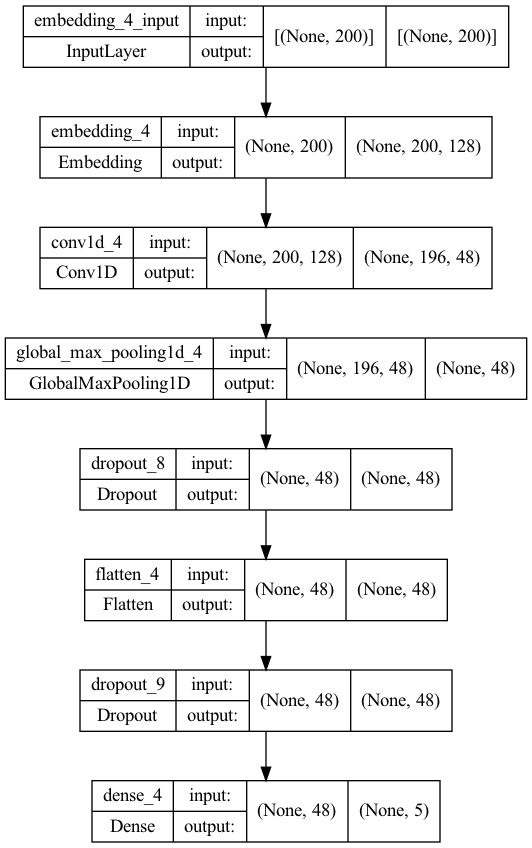

In [65]:
# initiate and define the model
model = Sequential()

model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))
model.add(Conv1D(48, 5, activation='relu', padding='valid'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# show the model structure
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [16]:
#compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
# save history in tensorboard
log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [18]:
# set parameters and train the model
epochs = 16
batch_size = 128

history = model.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    validation_split=0.2,
                    callbacks=[tensorboard_callback])

Epoch 1/16


2022-08-21 18:23:22.449674: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-21 18:23:22.695780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2216/2216 [==============================] - ETA: 0s - loss: 0.9634 - accuracy: 0.6319

2022-08-21 18:25:38.238539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2216/2216 [==============================] - 142s 64ms/step - loss: 0.9634 - accuracy: 0.6319 - val_loss: 0.7729 - val_accuracy: 0.6894
Epoch 2/16
2216/2216 [==============================] - 83s 37ms/step - loss: 0.8290 - accuracy: 0.6746 - val_loss: 0.7594 - val_accuracy: 0.6926
Epoch 3/16
2216/2216 [==============================] - 84s 38ms/step - loss: 0.7875 - accuracy: 0.6884 - val_loss: 0.7544 - val_accuracy: 0.6947
Epoch 4/16
2216/2216 [==============================] - 84s 38ms/step - loss: 0.7526 - accuracy: 0.7001 - val_loss: 0.7573 - val_accuracy: 0.6944
Epoch 5/16
2216/2216 [==============================] - 96s 43ms/step - loss: 0.7223 - accuracy: 0.7111 - val_loss: 0.7675 - val_accuracy: 0.6928
Epoch 6/16
2216/2216 [==============================] - 102s 46ms/step - loss: 0.6959 - accuracy: 0.7216 - val_loss: 0.7876 - val_accuracy: 0.6897
Epoch 7/16
2216/2216 [==============================] - 107s 48ms/step - loss: 0.6736 - accuracy: 0.7318 - val_loss: 0.8002 - val_acc

In [30]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_padded, test_labels, batch_size=128)

Evaluate on test data
693/693 [==============================] - 7s 11ms/step - loss: 1.0378 - accuracy: 0.6686


In [ ]:
#look at tensorboard
%tensorboard --logdir logs/fit